## Hyperparameter Tuning with GridSearchCV and MLflow Tracking for Multiple Models Using a Validation Set

### Step 1: Import Libraries

In [57]:
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, make_scorer

### Step 2: Load and Split the Dataset

In [58]:
# Load and split data
digits = load_digits()
digits.data.shape

(1797, 64)

<Figure size 640x480 with 0 Axes>

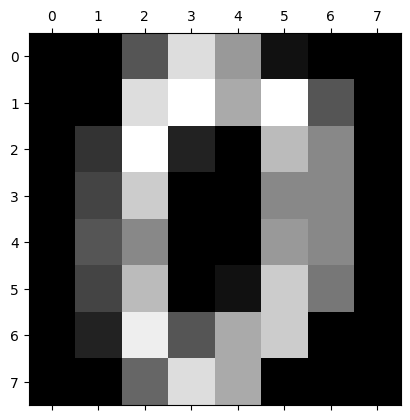

0


In [59]:
plt.gray()
plt.matshow(digits.images[0])
plt.show()
print(digits.target[0])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [61]:
# Define model and parameter grid
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [62]:
# SVM
svm_model = SVC()
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [63]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)

accuracy_scorer = make_scorer(custom_scorer)

In [64]:
# Random Forest GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [65]:
# SVM GridSearchCV
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

In [66]:
def log_cv_results_to_mlflow(cv_results):
    for i in range(len(cv_results['params'])):
        with mlflow.start_run(nested=True):
            mlflow.log_params(cv_results['params'][i])
            mlflow.log_metric('mean_test_score', cv_results['mean_test_score'][i])
            mlflow.log_metric('std_test_score', cv_results['std_test_score'][i])
            mlflow.log_metric('rank_test_score', cv_results['rank_test_score'][i])


In [67]:
def log_dataset_info():
    mlflow.set_tag('dataset_name', 'Digits')
    mlflow.set_tag('feature_names', digits.feature_names)
    mlflow.set_tag('target_names', digits.target_names.tolist())
    mlflow.log_param('num_features', X_train.shape[1])
    mlflow.log_param('num_train_samples', X_train.shape[0])
    mlflow.log_param('num_val_samples', X_val.shape[0])
    mlflow.log_param('num_test_samples', X_test.shape[0])


In [68]:
# Start a parent run for Random Forest
with mlflow.start_run(run_name="GridSearchCV_RandomForest") as rf_parent_run:
    # Log dataset information
    log_dataset_info()
    
    rf_grid_search.fit(X_train, y_train)
    
    # Log the best estimator in a separate, clearly designated run
    with mlflow.start_run(run_name="BestModel_RandomForest", nested=True) as rf_best_model_run:
        mlflow.sklearn.log_model(rf_grid_search.best_estimator_, "best_model_rf")
        mlflow.log_params(rf_grid_search.best_params_)
        mlflow.log_metric('best_score', rf_grid_search.best_score_)
        mlflow.set_tag('parent_run_id', rf_parent_run.info.run_id)

    # Log all results for hyperparameter tuning
    log_cv_results_to_mlflow(rf_grid_search.cv_results_)

    # Evaluate on validation set and log the accuracy
    y_val_pred = rf_grid_search.predict(X_val)
    rf_val_accuracy = accuracy_score(y_val, y_val_pred)
    mlflow.log_metric('val_accuracy_rf', rf_val_accuracy)
    mlflow.set_tag('model_type', 'RandomForest')


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_sa

In [69]:
# Start a parent run for SVM
with mlflow.start_run(run_name="GridSearchCV_SVM") as svm_parent_run:
    # Log dataset information
    log_dataset_info()
    
    svm_grid_search.fit(X_train, y_train)
    
    # Log the best estimator in a separate, clearly designated run
    with mlflow.start_run(run_name="BestModel_SVM", nested=True) as svm_best_model_run:
        mlflow.sklearn.log_model(svm_grid_search.best_estimator_, "best_model_svm")
        mlflow.log_params(svm_grid_search.best_params_)
        mlflow.log_metric('best_score', svm_grid_search.best_score_)
        mlflow.set_tag('parent_run_id', svm_parent_run.info.run_id)

    # Log all results for hyperparameter tuning
    log_cv_results_to_mlflow(svm_grid_search.cv_results_)

    # Evaluate on validation set and log the accuracy
    y_val_pred = svm_grid_search.predict(X_val)
    svm_val_accuracy = accuracy_score(y_val, y_val_pred)
    mlflow.log_metric('val_accuracy_svm', svm_val_accuracy)
    mlflow.set_tag('model_type', 'SVM')


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale

In [70]:
# Evaluate Random Forest on test set
with mlflow.start_run(run_name="Test_Evaluation_RandomForest", nested=True):
    y_test_pred_rf = rf_grid_search.predict(X_test)
    rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)
    mlflow.log_metric('test_accuracy_rf', rf_test_accuracy)
    mlflow.set_tag('model_type', 'RandomForest')
    mlflow.set_tag('parent_run_id', rf_parent_run.info.run_id)

# Evaluate SVM on test set
with mlflow.start_run(run_name="Test_Evaluation_SVM", nested=True):
    y_test_pred_svm = svm_grid_search.predict(X_test)
    svm_test_accuracy = accuracy_score(y_test, y_test_pred_svm)
    mlflow.log_metric('test_accuracy_svm', svm_test_accuracy)
    mlflow.set_tag('model_type', 'SVM')
    mlflow.set_tag('parent_run_id', svm_parent_run.info.run_id)
